train time:0.091000s
[0.8545734]
test time:0.001001s
217 0.6676923076923077


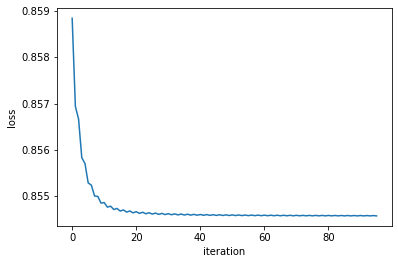

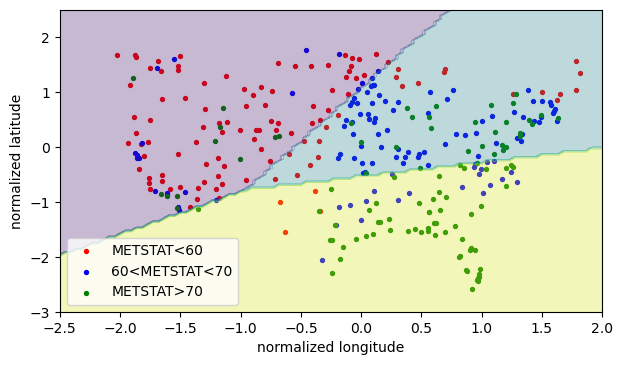

In [2]:
from autograd import grad
from autograd import numpy as np
import matplotlib.pyplot as plt
from autograd.misc.flatten import flatten_func
import pandas as pd
import time


#read dataset from file(already shuffled)
data = pd.read_csv("dataCollection.csv")

number = data['USAF'].values
latitude = data['Latitude'].values
longitude = data['Longitude'].values
metstat = data['Avg hourly METSTAT in 2005 (Wh/m^2)'].values
length = number.size
train_length = 600
test_length = length - train_length
classes = np.empty(length,dtype=int)

#standard normalization
var_x = np.var(longitude)
var_y = np.var(latitude)
mean_x = np.mean(longitude)
mean_y = np.mean(latitude)
x_norm = (longitude - mean_x)/np.sqrt(var_x)
y_norm = (latitude - mean_y)/np.sqrt(var_y)
N = 2 #No. of features


#define classes labels
C = 3 # No. of classes
for i in range(length):
    if metstat[i] < 60:
        classes[i]=0
    elif 60 <= metstat[i] < 70:
        classes[i]=1
    else:
        classes[i]=2


#split shuffled data for training and testing
x_train = x_norm[:train_length]
y_train = y_norm[:train_length]
classes_train = classes[:train_length]
x_test = x_norm[train_length:]
y_test = y_norm[train_length:]
classes_test = classes[train_length:]


# define model, which compute C linear combinations, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T


#define softmax function
def softmax(x):
    # max = np.max(x,axis=0,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x) #subtracts each row with its max value
    sum = np.sum(e_x,axis=0,keepdims=True) #returns sum of each row and keeps same dims
    return np.log(sum)


# multiclass perceptron cost function
lam = 10 # reg param
def multiclass_perceptron(w):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    # compute max across data points
    a = softmax(all_evals)
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int),np.arange(np.size(y))]
    cost = np.sum(a-b)
    # add regularization parameter
    cost = cost + lam*np.linalg.norm(w[1:,:])**2
    # return average
    return cost/float(np.size(y))


# gradient descent function
def gradient_descent(g, step, max_its, w):
    # flatten g
    g_flat, unflatten_func, w_flat = flatten_func(g,w)
    # compute gradient
    gradient = grad(g_flat)
    # gradient descent loop
    weight_history = [w_flat] # weight history container
    cost_history = [g_flat(w_flat)] # cost history container
    for k in range(max_its):
        # eval gradient
        grad_eval = gradient(w_flat)
        grad_eval_norm = grad_eval / np.linalg.norm(grad_eval)
        # take grad descent step
        alpha = 1/(k+1)
        w_flat = w_flat - alpha*grad_eval_norm
        # record weight and cost
        weight_history.append(w_flat)
        cost_history.append(g_flat(w_flat))
    return weight_history, cost_history, unflatten_func


#train models
x = np.c_[x_train,y_train].T
y = classes_train.T.reshape(1,-1)
w = np.random.random((N+1,C)) #w0, w1, w2
iter = 100

train_start = time.time()
a, b, unflatten = gradient_descent(multiclass_perceptron,'d',iter,w)
wp = unflatten(a[iter])
train_end = time.time()
print("train time:%fs"%(train_end-train_start))


#plot loss curve
plt.figure(1)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(b[5:])
print(b[-1])


#verify test dataset using trained classifier
data_verify = np.c_[x_test,y_test].T
test_start = time.time()
verify_result =np.argmax(model(data_verify, wp),axis=0)
test_end = time.time()
print("test time:%fs"%(test_end-test_start))
true_number = 0
for i in range(test_length):
    if verify_result[i] == classes_test[i]:
        true_number = true_number +1
print(true_number, true_number/test_length)


#plot test result
colors = ['r','b','g']
labels = ['METSTAT<60','60<METSTAT<70','METSTAT>70']
plt.figure(figsize=(7,4),dpi=100)
plt.xlabel('normalized longitude')
plt.ylabel('normalized latitude')
plt.xlim(-2.5, 2)
plt.ylim(-3, 2.5)
for target in range(C):
    plt.scatter(x_test[classes_test==target], y_test[classes_test==target], label=labels[target], c=colors[target],s=8)

xp1, xp2 = np.meshgrid(np.linspace(-2.5, 2,100),np.linspace(-3, 2.5, 100))
xp1_v = xp1.reshape(-1,1)
xp2_v = xp2.reshape(-1,1)
Xp_data = np.append(xp1_v,xp2_v,axis=1)
classes_area=np.argmax(model(Xp_data.T,wp),axis=0)
classes_area=classes_area.reshape(xp1.shape)
plt.contourf(xp1,xp2,classes_area, alpha=.3)
plt.legend()


#confusion matrix
